In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR


import numpy as np
from fastdtw import fastdtw
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
import torch

from model import ODEGCN
from utils import MyDataset, read_data, get_normalized_adj
from eval import masked_mae_np, masked_mape_np, masked_rmse_np

from torch.utils.data import DataLoader, random_split

import ray
import flwr as fl
if torch.cuda. is_available():
    print("Using Cuda!")
    DEVICE = torch.device("cuda")
else:
    print("Using CPU")
    DEVICE = torch.device("cpu")

Using CPU


In [2]:
class Args:
    def __init__(self):
        self.remote = False
        self.num_gpu = 0
        self.epochs = 20
        self.batch_size = 16
        self.batch = 16
        self.frac = 0.1
        self.num_users = 100
        self.filename = 'pems08'
        self.train_ratio = 0.6
        self.valid_ratio = 0.2
        self.his_length = 12
        self.pred_length = 12
        self.sigma1 = 0.1
        self.sigma2 = 10
        self.thres1 = 0.6
        self.thres2 = 0.5
        self.lr = 2e-3
        self.log = False

args = Args()

In [11]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    print('works till here', len(state_dict))
    net.load_state_dict(state_dict, strict=True)
    

In [12]:
def train(loader, model, optimizer, criterion, epochs, scheduler, device):

    for epoch in range(1, args.epochs+1):
        batch_loss = 0
        for idx, (inputs, targets) in enumerate(tqdm(loader)):
            model.train()
            optimizer.zero_grad()

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            batch_loss += loss.detach().cpu().item() 
        loss = batch_loss
       
        train_rmse, train_mae, train_mape = eval(loader, model, model.std, model.mean, device)

        if args.log:
            logger.info(f'\n##on train data## loss: {loss}, \n' + 
                        f'##on train data## rmse loss: {train_rmse}, mae loss: {train_mae}, mape loss: {train_mape}\n')
        else:
            print(f'\n##on train data## loss: {loss}, \n' + 
                f'##on train data## rmse loss: {train_rmse}, mae loss: {train_mae}, mape loss: {train_mape}\n')
        
        scheduler.step()

    scheduler.step()
    return batch_loss / (idx + 1)


@torch.no_grad()
def eval(loader, model, std, mean, device):
    batch_rmse_loss = 0  
    batch_mae_loss = 0
    batch_mape_loss = 0
    for idx, (inputs, targets) in enumerate(tqdm(loader)):
        model.eval()

        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        
        out_unnorm = output.detach().cpu().numpy()*std + mean
        target_unnorm = targets.detach().cpu().numpy()*std + mean

        mae_loss = masked_mae_np(target_unnorm, out_unnorm, 0)
        rmse_loss = masked_rmse_np(target_unnorm, out_unnorm, 0)
        mape_loss = masked_mape_np(target_unnorm, out_unnorm, 0)
        batch_rmse_loss += rmse_loss
        batch_mae_loss += mae_loss
        batch_mape_loss += mape_loss

    return batch_rmse_loss / (idx + 1), batch_mae_loss / (idx + 1), batch_mape_loss / (idx + 1)

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, optimiser, schedular, learning_rate, epochs, loss_function, ):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimiser = torch.optim.AdamW(net.parameters(), lr=self.learning_rate)
        self.scheduler = StepLR(self.optimiser, step_size=50, gamma=0.5)

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.trainloader, self.net, self.optimiser ,  self.loss_function, self.epochs, self.scheduler, DEVICE)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        valid_rmse, valid_mae, valid_mape = eval(valid_loader, net, std, mean, device)
        return valid_rmse, valid_mae, valid_mape

In [14]:
def generate_dataset(data, args):
    """
    Args:
        data: input dataset, shape like T * N
        batch_size: int 
        train_ratio: float, the ratio of the dataset for training
        his_length: the input length of time series for prediction
        pred_length: the target length of time series of prediction

    Returns:
        train_dataloader: torch tensor, shape like batch * N * his_length * features
        test_dataloader: torch tensor, shape like batch * N * pred_length * features
    """
    batch_size = args.batch_size
    train_ratio = args.train_ratio
    valid_ratio = args.valid_ratio
    his_length = args.his_length
    pred_length = args.pred_length
    train_dataset = MyDataset(data, 0, data.shape[0] * train_ratio, his_length, pred_length)

    valid_dataset = MyDataset(data, data.shape[0]*train_ratio, data.shape[0]*(train_ratio+valid_ratio), his_length, pred_length)

    test_dataset = MyDataset(data, data.shape[0]*(train_ratio+valid_ratio), data.shape[0], his_length, pred_length)

    return train_dataset, valid_dataset, test_dataset

In [15]:
if args.log:
    logger.add('log_{time}.log')
options = vars(args)
if args.log:
    logger.info(options)
else:
    print(options)

data, mean, std, dtw_matrix, sp_matrix = read_data(args)
train_loader, valid_loader, test_loader = generate_dataset(data, args)
A_sp_wave = get_normalized_adj(sp_matrix).to(DEVICE)
A_se_wave = get_normalized_adj(dtw_matrix).to(DEVICE)

epoch = args.epochs
NUM_CLIENTS = 8
#trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS, args.batch_size, train_x, train_y, test_x, test_y)

'''net = ODEGCN(num_nodes=data.shape[1], 
            num_features=data.shape[2], 
            num_timesteps_input=args.his_length, 
            num_timesteps_output=args.pred_length, 
            A_sp_hat=A_sp_wave, 
            A_se_hat=A_se_wave)

net.std = std
net.mean = mean

w_glob = net.state_dict()
net_glob = net

net = net.to(DEVICE)'''
lr = args.lr
#optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()

#best_valid_rmse = 1000 
#scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

{'remote': False, 'num_gpu': 0, 'epochs': 20, 'batch_size': 16, 'batch': 16, 'frac': 0.1, 'num_users': 100, 'filename': 'pems08', 'train_ratio': 0.6, 'valid_ratio': 0.2, 'his_length': 12, 'pred_length': 12, 'sigma1': 0.1, 'sigma2': 10, 'thres1': 0.6, 'thres2': 0.5, 'lr': 0.002, 'log': False}
average degree of spatial graph is 1.6058823529411765
average degree of semantic graph is 3.0764705882352943


In [16]:
batch_size = args.batch_size
train_loader = Subset(train_loader, np.arange(1000))
valid_loader = Subset(valid_loader, np.arange(200))
inds = np.array_split(np.random.randint(len(train_loader), size=len(train_loader)), NUM_CLIENTS)
trainloaders = []
valloaders = []
for idx in inds:
    trainloaders.append(DataLoader(Subset(train_loader, idx), batch_size=batch_size, shuffle=True))


inds = np.array_split(np.random.randint(len(valid_loader), size=len(valid_loader)), NUM_CLIENTS)
for idx in inds:
    valloaders.append(DataLoader(Subset(valid_loader, idx), batch_size=batch_size, shuffle=True))

In [17]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    epochs = 2
    # Load model
    learning_rate = lr
    net = ODEGCN(num_nodes=data.shape[1], 
            num_features=data.shape[2], 
            num_timesteps_input=args.his_length, 
            num_timesteps_output=args.pred_length, 
            A_sp_hat=A_sp_wave, 
            A_se_hat=A_se_wave).to(DEVICE)
    #net.std = std
    #net.mean = mean

    w_glob = net.state_dict()
    
    net.load_state_dict(w_glob, strict=True)
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net=net, trainloader=trainloader, valloader=valloader, optimiser=None , schedular=None,learning_rate=learning_rate, 
                        epochs=epochs , loss_function= criterion )

In [18]:
#params = get_parameters(ShallowRegressionLSTM(input_size=train_x.shape[1], hidden_units=num_hidden_units))

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-20 01:44:53,383 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-04-20 01:44:57,944	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-20 01:45:00,221 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 8509043508.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-04-20 01:45:00,221 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-20 01:45:00,221 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-20 01:45:01,313 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-20 01:45:01,314 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-20 01:45:01,314 | server.py:101 | FL starting
DEBUG flwr 2023-04-20 01:45:01,314 | server.py:215 | fit_round 1: strategy sampled 8 clients (out of 8)
DEBUG flwr 2023-04-20 01:45:01,773 | ray_client_proxy.py:87 | 

(launch_and_fit pid=34474) works till here 328


DEBUG flwr 2023-04-20 01:45:03,078 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=34471, ip=127.0.0.1)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000gn/T/ipykernel_34426/2395207088.py", line 16, in fit
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000gn/T/ipykernel_34426/1384533540.py", line 9, in

(launch_and_fit pid=34471) works till here 328


DEBUG flwr 2023-04-20 01:45:03,171 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=34477, ip=127.0.0.1)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/app.py", line 258, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000gn/T/ipykernel_34426/2395207088.py", line 16, in fit
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000gn/T/ipykernel_34426/1384533540.py", line 9, in

(launch_and_fit pid=34476) works till here 328
(launch_and_fit pid=34477) works till here 328
(launch_and_fit pid=34475) works till here 328
(launch_and_fit pid=34473) works till here 328
(launch_and_fit pid=34470) works till here 328
(launch_and_fit pid=34472) works till here 328


DEBUG flwr 2023-04-20 01:45:03,809 | ray_client_proxy.py:104 | ray::launch_and_evaluate() (pid=34470, ip=127.0.0.1)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 160, in launch_and_evaluate
    return maybe_call_evaluate(
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/client.py", line 205, in maybe_call_evaluate
    return client.evaluate(evaluate_ins)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/app.py", line 282, in _evaluate
    results = self.numpy_client.evaluate(parameters, ins.config)  # type: ignore
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000gn/T/ipykernel_34426/2395207088.py", line 21, in evaluate
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000g

(launch_and_evaluate pid=34470) works till here 328


DEBUG flwr 2023-04-20 01:45:04,121 | ray_client_proxy.py:104 | ray::launch_and_evaluate() (pid=34473, ip=127.0.0.1)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 160, in launch_and_evaluate
    return maybe_call_evaluate(
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/client.py", line 205, in maybe_call_evaluate
    return client.evaluate(evaluate_ins)
  File "/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/client/app.py", line 282, in _evaluate
    results = self.numpy_client.evaluate(parameters, ins.config)  # type: ignore
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000gn/T/ipykernel_34426/2395207088.py", line 21, in evaluate
  File "/var/folders/68/5k14l04j0x90xzkf8zln44r00000g

(launch_and_evaluate pid=34473) works till here 328
(launch_and_evaluate pid=34472) works till here 328
(launch_and_evaluate pid=34475) works till here 328


KeyboardInterrupt: 

(launch_and_evaluate pid=34476) works till here 328


In [19]:
net = ODEGCN(num_nodes=data.shape[1], 
            num_features=data.shape[2], 
            num_timesteps_input=args.his_length, 
            num_timesteps_output=args.pred_length, 
            A_sp_hat=A_sp_wave, 
            A_se_hat=A_se_wave).to(DEVICE)
    #net.std = std
    #net.mean = mean
w_glob = net.state_dict()
    

net.load_state_dict(w_glob, strict=True)

<All keys matched successfully>

In [99]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    print('works till here', len(state_dict))
    net.load_state_dict(state_dict, strict=True)

In [103]:
[i.shape for i in parameters] == [val.cpu().numpy().shape for _, val in net.state_dict().items()]

True

In [168]:
w_glob = net.state_dict()
net.load_state_dict(w_glob, strict=True)
parameters = [val.cpu().numpy() for _, val in net.state_dict().items()]
params_dict = zip(net.state_dict().keys(), parameters)
#torch.rand(16, 170, 12, 3).shape
net(torch.rand(16, 170, 12, 3))

state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
net.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

TypeError: '_SingleProcessDataLoaderIter' object is not subscriptable

In [163]:
next(iter(trainloaders[0]))[0].shape

torch.Size([16, 170, 12, 3])

In [164]:
torch.rand(16,170,12).shape
torch.rand(16, 170, 12, 3).shape

torch.Size([16, 170, 12, 3])

In [93]:
parameters = [val.cpu().numpy() for _, val in net.state_dict().items()]


In [95]:
parameters[27].shape

()

In [97]:
net.state_dict()['sp_blocks.0.0.batch_norm.num_batches_tracked'].shape

torch.Size([])

In [62]:
for (x, y), (w,z) in zip(state_dict.items(), w_glob.items()):
    print(w, '**name**',y.shape, '--', z.shape)

sp_blocks.0.0.temporal1.conv.weight **name** torch.Size([4]) -- torch.Size([64, 32, 1, 2])
sp_blocks.0.0.temporal1.conv.bias **name** torch.Size([1]) -- torch.Size([64])
sp_blocks.0.0.temporal1.network.0.0.weight **name** torch.Size([4]) -- torch.Size([64, 3, 1, 2])
sp_blocks.0.0.temporal1.network.0.0.bias **name** torch.Size([1]) -- torch.Size([64])
sp_blocks.0.0.temporal1.network.1.0.weight **name** torch.Size([4]) -- torch.Size([32, 64, 1, 2])
sp_blocks.0.0.temporal1.network.1.0.bias **name** torch.Size([1]) -- torch.Size([32])
sp_blocks.0.0.temporal1.network.2.0.weight **name** torch.Size([4]) -- torch.Size([64, 32, 1, 2])
sp_blocks.0.0.temporal1.network.2.0.bias **name** torch.Size([1]) -- torch.Size([64])
sp_blocks.0.0.temporal1.downsample.weight **name** torch.Size([4]) -- torch.Size([64, 3, 1, 1])
sp_blocks.0.0.temporal1.downsample.bias **name** torch.Size([1]) -- torch.Size([64])
sp_blocks.0.0.odeg.odeblock.odefunc.alpha **name** torch.Size([1]) -- torch.Size([170])
sp_blocks.

In [72]:
net.state_dict()['sp_blocks.0.0.batch_norm.num_batches_tracked']

tensor(0)

In [74]:
dict({k: torch.Tensor(v) for k, v in params_dict})

{}

In [70]:
net.state_dict()

OrderedDict([('sp_blocks.0.0.temporal1.conv.weight',
              tensor([[[[-0.0094, -0.0025]],
              
                       [[-0.0002,  0.0056]],
              
                       [[-0.0008, -0.0017]],
              
                       ...,
              
                       [[ 0.0031, -0.0025]],
              
                       [[ 0.0103,  0.0105]],
              
                       [[ 0.0095, -0.0001]]],
              
              
                      [[[ 0.0063,  0.0002]],
              
                       [[ 0.0016,  0.0111]],
              
                       [[ 0.0099, -0.0146]],
              
                       ...,
              
                       [[-0.0052, -0.0012]],
              
                       [[-0.0077, -0.0055]],
              
                       [[-0.0109,  0.0049]]],
              
              
                      [[[-0.0118,  0.0120]],
              
                       [[-0.0154,  0.0072]],
    

In [44]:
for x, y in zip(w_glob, state_dict):
    print(x==y)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [35]:
print(w_glob.keys())

odict_keys(['sp_blocks.0.0.temporal1.conv.weight', 'sp_blocks.0.0.temporal1.conv.bias', 'sp_blocks.0.0.temporal1.network.0.0.weight', 'sp_blocks.0.0.temporal1.network.0.0.bias', 'sp_blocks.0.0.temporal1.network.1.0.weight', 'sp_blocks.0.0.temporal1.network.1.0.bias', 'sp_blocks.0.0.temporal1.network.2.0.weight', 'sp_blocks.0.0.temporal1.network.2.0.bias', 'sp_blocks.0.0.temporal1.downsample.weight', 'sp_blocks.0.0.temporal1.downsample.bias', 'sp_blocks.0.0.odeg.odeblock.odefunc.alpha', 'sp_blocks.0.0.odeg.odeblock.odefunc.w', 'sp_blocks.0.0.odeg.odeblock.odefunc.d', 'sp_blocks.0.0.odeg.odeblock.odefunc.w2', 'sp_blocks.0.0.odeg.odeblock.odefunc.d2', 'sp_blocks.0.0.temporal2.conv.weight', 'sp_blocks.0.0.temporal2.conv.bias', 'sp_blocks.0.0.temporal2.network.0.0.weight', 'sp_blocks.0.0.temporal2.network.0.0.bias', 'sp_blocks.0.0.temporal2.network.1.0.weight', 'sp_blocks.0.0.temporal2.network.1.0.bias', 'sp_blocks.0.0.temporal2.network.2.0.weight', 'sp_blocks.0.0.temporal2.network.2.0.bias

In [36]:
parameters.keys()

AttributeError: 'list' object has no attribute 'keys'

In [31]:
w_glob

OrderedDict([('sp_blocks.0.0.temporal1.conv.weight',
              tensor([[[[-0.0094, -0.0025]],
              
                       [[-0.0002,  0.0056]],
              
                       [[-0.0008, -0.0017]],
              
                       ...,
              
                       [[ 0.0031, -0.0025]],
              
                       [[ 0.0103,  0.0105]],
              
                       [[ 0.0095, -0.0001]]],
              
              
                      [[[ 0.0063,  0.0002]],
              
                       [[ 0.0016,  0.0111]],
              
                       [[ 0.0099, -0.0146]],
              
                       ...,
              
                       [[-0.0052, -0.0012]],
              
                       [[-0.0077, -0.0055]],
              
                       [[-0.0109,  0.0049]]],
              
              
                      [[[-0.0118,  0.0120]],
              
                       [[-0.0154,  0.0072]],
    

In [22]:
set_parameters(net, paramss)

works till here 328


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [25]:
paramss[0].shape

(64, 32, 1, 2)

In [15]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from loguru import logger

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR


import numpy as np
from fastdtw import fastdtw
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
import torch

from model import ODEGCN
from utils import MyDataset, read_data, get_normalized_adj
from eval import masked_mae_np, masked_mape_np, masked_rmse_np

from torch.utils.data import DataLoader, random_split

import ray
import flwr as fl
if torch.cuda. is_available():
    print("Using Cuda!")
    DEVICE = torch.device("cuda")
else:
    print("Using CPU")
    DEVICE = torch.device("cpu")



class Args:
    def __init__(self):
        self.remote = False
        self.num_gpu = 0
        self.epochs = 20
        self.batch_size = 16
        self.batch = 16
        self.frac = 0.1
        self.num_users = 100
        self.filename = 'pems08'
        self.train_ratio = 0.6
        self.valid_ratio = 0.2
        self.his_length = 12
        self.pred_length = 12
        self.sigma1 = 0.1
        self.sigma2 = 10
        self.thres1 = 0.6
        self.thres2 = 0.5
        self.lr = 2e-3
        self.log = False

args = Args()



def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    #print('works till here', len(state_dict))
    net.load_state_dict(state_dict, strict=True)



def train(loader, model, optimizer, criterion, epochs, scheduler, std, mean, device):

    for epoch in range(1, epochs+1):
        batch_loss = 0
        for idx, (inputs, targets) in enumerate(tqdm(loader)):
            model.train()
            optimizer.zero_grad()

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            batch_loss += loss.detach().cpu().item() 
        loss = batch_loss
       
        train_rmse, train_mae, train_mape = eval(loader, model, std, mean, device)

        if args.log:
            logger.info(f'\n##on train data## loss: {loss}, \n' + 
                        f'##on train data## rmse loss: {train_rmse}, mae loss: {train_mae}, mape loss: {train_mape}\n')
        else:
            print(f'\n##on train data## loss: {loss}, \n' + 
                f'##on train data## rmse loss: {train_rmse}, mae loss: {train_mae}, mape loss: {train_mape}\n')
        
        scheduler.step()

    scheduler.step()
    return batch_loss / (idx + 1)


@torch.no_grad()
def eval(loader, model, std, mean, device):
    batch_rmse_loss = 0  
    batch_mae_loss = 0
    batch_mape_loss = 0
    for idx, (inputs, targets) in enumerate(tqdm(loader)):
        model.eval()

        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        
        out_unnorm = output.detach().cpu().numpy()*std + mean
        target_unnorm = targets.detach().cpu().numpy()*std + mean

        mae_loss = masked_mae_np(target_unnorm, out_unnorm, 0)
        rmse_loss = masked_rmse_np(target_unnorm, out_unnorm, 0)
        mape_loss = masked_mape_np(target_unnorm, out_unnorm, 0)
        batch_rmse_loss += rmse_loss
        batch_mae_loss += mae_loss
        batch_mape_loss += mape_loss
    print("eval loss: ", batch_rmse_loss)

    return batch_rmse_loss / (idx + 1), batch_mae_loss / (idx + 1), batch_mape_loss / (idx + 1)


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, optimiser, schedular, learning_rate, epochs, loss_function, mean, std ):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimiser = torch.optim.AdamW(net.parameters(), lr=self.learning_rate)
        self.scheduler = StepLR(self.optimiser, step_size=50, gamma=0.5)
        self.mean = mean
        self.std = std

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.trainloader, self.net, self.optimiser ,  self.loss_function, self.epochs, self.scheduler, self.std, self.mean, DEVICE)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        valid_rmse, valid_mae, valid_mape = eval(self.valid_loader, net, self.std, self.mean, device)
        return valid_rmse, valid_mae, valid_mape
    


def generate_dataset(data, args):
    """
    Args:
        data: input dataset, shape like T * N
        batch_size: int 
        train_ratio: float, the ratio of the dataset for training
        his_length: the input length of time series for prediction
        pred_length: the target length of time series of prediction

    Returns:
        train_dataloader: torch tensor, shape like batch * N * his_length * features
        test_dataloader: torch tensor, shape like batch * N * pred_length * features
    """
    batch_size = args.batch_size
    train_ratio = args.train_ratio
    valid_ratio = args.valid_ratio
    his_length = args.his_length
    pred_length = args.pred_length
    train_dataset = MyDataset(data, 0, data.shape[0] * train_ratio, his_length, pred_length)

    valid_dataset = MyDataset(data, data.shape[0]*train_ratio, data.shape[0]*(train_ratio+valid_ratio), his_length, pred_length)

    test_dataset = MyDataset(data, data.shape[0]*(train_ratio+valid_ratio), data.shape[0], his_length, pred_length)

    return train_dataset, valid_dataset, test_dataset




if args.log:
    logger.add('log_{time}.log')
options = vars(args)
if args.log:
    logger.info(options)
else:
    print(options)

data, mean, std, dtw_matrix, sp_matrix = read_data(args)
train_loader, valid_loader, test_loader = generate_dataset(data, args)
A_sp_wave = get_normalized_adj(sp_matrix).to(DEVICE)
A_se_wave = get_normalized_adj(dtw_matrix).to(DEVICE)

epoch = args.epochs
NUM_CLIENTS = 8
#trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS, args.batch_size, train_x, train_y, test_x, test_y)

'''net = ODEGCN(num_nodes=data.shape[1], 
            num_features=data.shape[2], 
            num_timesteps_input=args.his_length, 
            num_timesteps_output=args.pred_length, 
            A_sp_hat=A_sp_wave, 
            A_se_hat=A_se_wave)

net.std = std
net.mean = mean

w_glob = net.state_dict()
net_glob = net

net = net.to(DEVICE)'''
lr = args.lr
#optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()

#best_valid_rmse = 1000 
#scheduler = StepLR(optimizer, step_size=50, gamma=0.5)



batch_size = args.batch_size
train_loader = Subset(train_loader, np.arange(1000))
valid_loader = Subset(valid_loader, np.arange(200))
inds = np.array_split(np.random.randint(len(train_loader), size=len(train_loader)), NUM_CLIENTS)
trainloaders = []
valloaders = []
for idx in inds:
    trainloaders.append(DataLoader(Subset(train_loader, idx), batch_size=batch_size, shuffle=True))


inds = np.array_split(np.random.randint(len(valid_loader), size=len(valid_loader)), NUM_CLIENTS)
for idx in inds:
    valloaders.append(DataLoader(Subset(valid_loader, idx), batch_size=batch_size, shuffle=True))



def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    epochs = 2
    # Load model
    learning_rate = lr
    c_mean = mean
    c_std = std
    net = ODEGCN(num_nodes=data.shape[1], 
            num_features=data.shape[2], 
            num_timesteps_input=args.his_length, 
            num_timesteps_output=args.pred_length, 
            A_sp_hat=A_sp_wave, 
            A_se_hat=A_se_wave).to(DEVICE)
    #net.std = std
    #net.mean = mean

    w_glob = net.state_dict()
    
    net.load_state_dict(w_glob, strict=True)
    net(torch.rand(16, 170, 12, 3))
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net=net, trainloader=trainloader, valloader=valloader, optimiser=None , schedular=None,learning_rate=learning_rate, 
                        epochs=epochs , loss_function= criterion , mean=c_mean, std=c_std)


#params = get_parameters(ShallowRegressionLSTM(input_size=train_x.shape[1], hidden_units=num_hidden_units))



Using CPU
{'remote': False, 'num_gpu': 0, 'epochs': 20, 'batch_size': 16, 'batch': 16, 'frac': 0.1, 'num_users': 100, 'filename': 'pems08', 'train_ratio': 0.6, 'valid_ratio': 0.2, 'his_length': 12, 'pred_length': 12, 'sigma1': 0.1, 'sigma2': 10, 'thres1': 0.6, 'thres2': 0.5, 'lr': 0.002, 'log': False}
average degree of spatial graph is 1.6058823529411765
average degree of semantic graph is 3.0764705882352943


In [18]:
valloaders[0].batch_size

16

In [6]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-20 12:22:42,487 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-04-20 12:22:46,895	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-20 12:22:49,192 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 7679441306.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-04-20 12:22:49,192 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-20 12:22:49,193 | server.py:270 | Requesting initial parameters from one random client


TypeError: Could not serialize the argument <function client_fn at 0x3278ec3a0> for a task or actor flwr.simulation.ray_transport.ray_client_proxy.launch_and_get_parameters. Check https://docs.ray.io/en/master/ray-core/objects/serialization.html#troubleshooting for more information.

In [29]:
import flwr as fl
import pickle

In [82]:
with open('flower_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [70]:
history.metrics_distributed

{'average_metrics': [(1,
   {'valid_mape': 1974759.3684895833,
    'valid_mae': 103.91737620035808,
    'valid_rmse': 129.53815816243488}),
  (2,
   {'valid_mape': 1382541.6357421875,
    'valid_mae': 49.049827829996744,
    'valid_rmse': 65.65994160970052}),
  (3,
   {'valid_mape': 1275338.7076822917,
    'valid_mae': 40.7147819519043,
    'valid_rmse': 53.084530639648435})],
 'client_metrics': [(1,
   {'valid_mape': [1520796.4518229167,
     1946068.4895833333,
     2115462.1744791665,
     1875467.2200520833,
     2416002.5065104165],
    'valid_mae': [104.83621724446614,
     101.80231475830078,
     103.64472961425781,
     101.4852803548177,
     107.81833902994792],
    'valid_rmse': [130.93990071614584,
     127.42596944173177,
     129.4236602783203,
     126.32016499837239,
     133.58109537760416],
    'examples': [48, 48, 48, 48, 48]}),
  (2,
   {'valid_mape': [803260.9293619791,
     1759455.859375,
     1539842.28515625,
     1621075.09765625,
     1189074.0071614583],
  

In [78]:
x, y = [], []
for average_metrics in history.metrics_distributed['average_metrics']:
    x.append(average_metrics[0])
    y.append(average_metrics[1]['valid_rmse'])

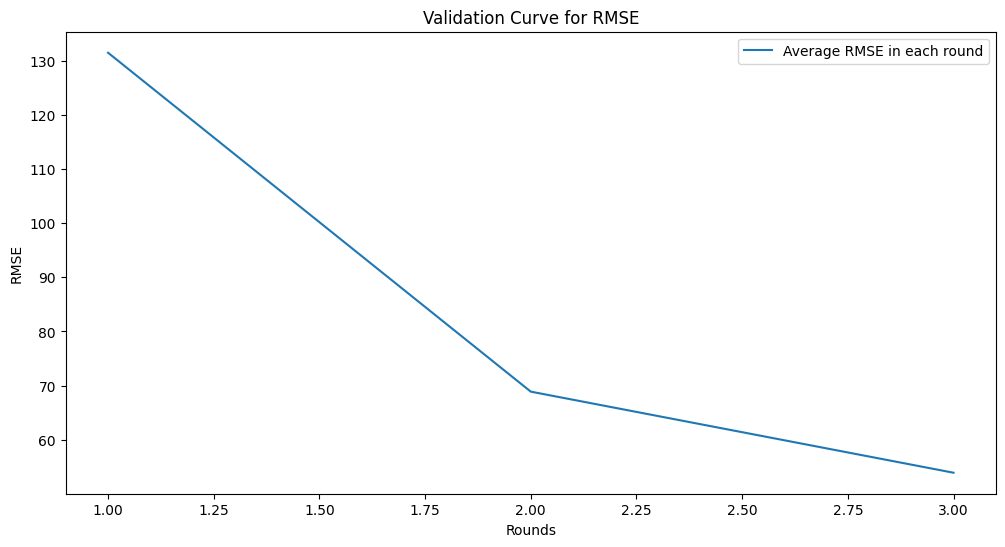

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(x, y, label='Average RMSE in each round')
plt.xlabel('Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Validation Curve for RMSE')
plt.show()

In [97]:
x =  []
y = [[] for i in history.metrics_distributed['client_metrics'][0][1]['valid_rmse']]
for client_metrics in history.metrics_distributed['client_metrics']:
    x.append(client_metrics[0])
    for idx, client_loss in enumerate(client_metrics[1]['valid_rmse']):
        y[idx].append(client_loss)

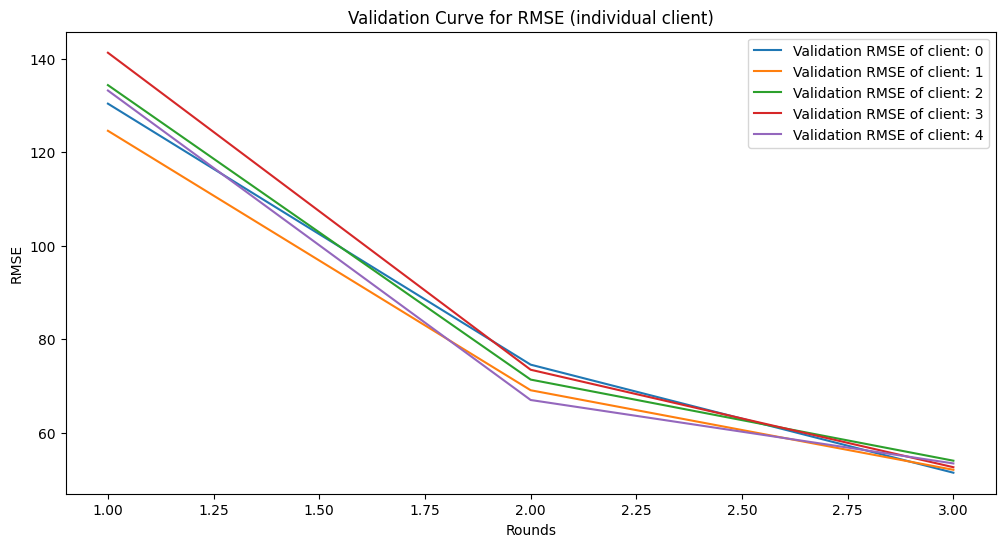

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for client_num, loss_ in enumerate(y):
    plt.plot(x, loss_, label='Validation RMSE of client: '+str(client_num))
plt.xlabel('Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Validation Curve for RMSE (individual client)')
plt.show()

In [83]:
history.metrics_distributed_fit

{'client_metrics': [(1,
   {'loss': [5.988854378461838,
     5.598665848374367,
     5.9691998064517975,
     5.987894713878632,
     5.746948480606079]}),
  (2,
   {'loss': [2.3636930249631405,
     2.3067092671990395,
     2.2398380748927593,
     2.588116690516472,
     2.648045029491186]}),
  (3,
   {'loss': [1.3516024611890316,
     1.463310956954956,
     1.4098910354077816,
     1.416612721979618,
     1.276380131021142]})],
 'examples': [(1, [208, 208, 208, 208, 208]),
  (2, [208, 208, 208, 208, 208]),
  (3, [208, 208, 208, 208, 208])],
 'average_metrics': [(1, {'average loss': 5.858312645554543}),
  (2, {'average loss': 2.4292804174125195}),
  (3, {'average loss': 1.3835594613105058})]}

In [93]:
y

[[5.988854378461838, 2.3636930249631405, 1.3516024611890316],
 [5.598665848374367, 2.3067092671990395, 1.463310956954956],
 [5.9691998064517975, 2.2398380748927593, 1.4098910354077816],
 [5.987894713878632, 2.588116690516472, 1.416612721979618],
 [5.746948480606079, 2.648045029491186, 1.276380131021142]]

In [91]:
x =  []
y = [[] for i in history.metrics_distributed_fit['client_metrics'][0][1]['loss']]
for client_metrics in history.metrics_distributed_fit['client_metrics']:
    x.append(client_metrics[0])
    for idx, client_loss in enumerate(client_metrics[1]['loss']):
        y[idx].append(client_loss)

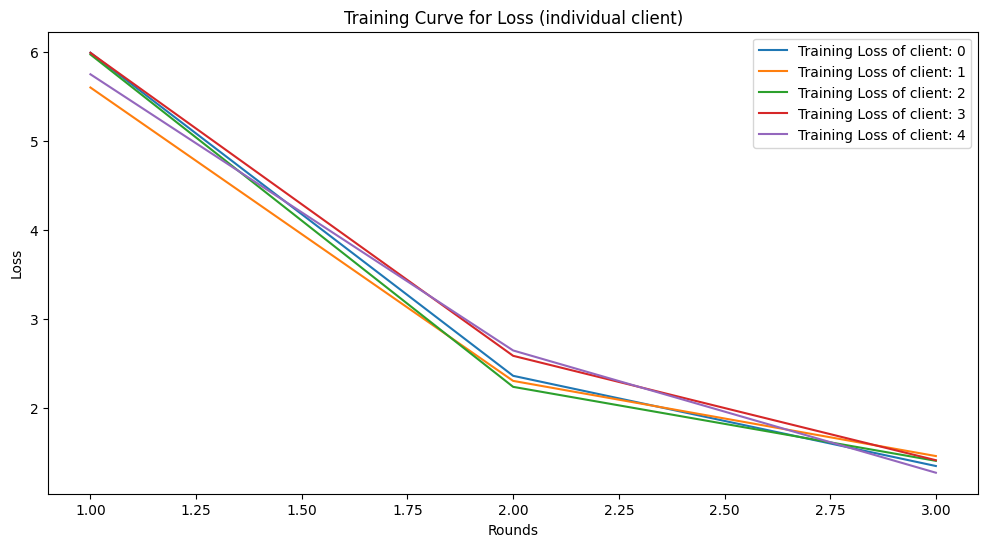

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for client_num, loss_ in enumerate(y):
    plt.plot(x, loss_, label='Training Loss of client: '+str(client_num))
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve for Loss (individual client)')
plt.show()

In [74]:
x, y = [], []
for average_metrics in history.metrics_distributed_fit['average_metrics']:
    x.append(average_metrics[0])
    y.append(average_metrics[1]['average loss'])

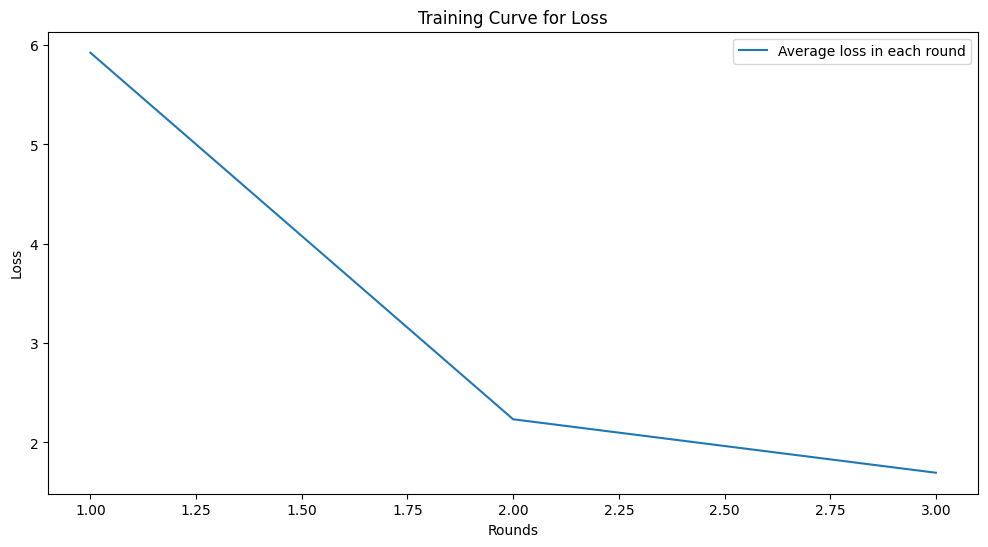

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(x, y, label='Average loss in each round')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve for Loss')
plt.show()

In [19]:
import flwr as fl

In [9]:
from flwr.common import Metrics

In [10]:
import typ

typing.Dict[str, typing.Union[bool, bytes, float, int, str]]

In [21]:
fl.simulation.

<module 'flwr.simulation' from '/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/lib/python3.9/site-packages/flwr/simulation/__init__.py'>

In [22]:
flwr.__version__

'1.3.0'

In [28]:
!pip3 install flwr-nightly.simulation

ERROR: Could not find a version that satisfies the requirement flwr-nightly.simulation (from versions: none)
ERROR: No matching distribution found for flwr-nightly.simulation
You should consider upgrading via the '/Users/ammar/Documents/ammar_documents/Minnesota/courses_spring_2023/CSCI_5525/project_env/bin/python3 -m pip install --upgrade pip' command.
